In [166]:
import pandas as pd
import numpy as np
import warnings
import concurrent.futures
#import missingno as msno
import MetaTrader5 as mt5

pd.options.display.max_columns = 100000
warnings.filterwarnings('ignore')

if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MT5 successfully initialised.\n")

MT5 successfully initialised.



In [167]:
def tick_rule(price):
    price = int(price)
    if price < int(1):
        return 0.005
    elif price >= int(1) and price < int(10):
        return 0.01
    elif price >= int(10) and price < int(100):
        return 0.02
    else:
        return 0.1

# Defining flag values
TICK_FLAG_BID = 2
TICK_FLAG_ASK = 4
TICK_FLAG_LAST = 8
TICK_FLAG_VOLUME = 16
TICK_FLAG_BUY = 32
TICK_FLAG_SELL = 64

def interpret_flags(flags):
    interpretations = []
    if flags & TICK_FLAG_BID:
        interpretations.append("TICK_FLAG_BID")
    if flags & TICK_FLAG_ASK:
        interpretations.append("TICK_FLAG_ASK")
    if flags & TICK_FLAG_LAST:
        interpretations.append("TICK_FLAG_LAST")
    if flags & TICK_FLAG_VOLUME:
        interpretations.append("TICK_FLAG_VOLUME")
    if flags & TICK_FLAG_BUY:
        interpretations.append("TICK_FLAG_BUY")
    if flags & TICK_FLAG_SELL:
        interpretations.append("TICK_FLAG_SELL")

    return interpretations

# Test with a flag value
flags_value = 88
interpreted_flags = interpret_flags(flags_value)
print(f"Interpretation of {flags_value} is {interpreted_flags}.")


Interpretation of 88 is ['TICK_FLAG_LAST', 'TICK_FLAG_VOLUME', 'TICK_FLAG_SELL'].


In [168]:
df = pd.DataFrame(mt5.copy_ticks_from('CIMB[A]',1, 500000, mt5.COPY_TICKS_TRADE))
df['time'] = pd.to_datetime(df['time_msc'], unit='ms')
df.set_index('time', inplace=True)

FLAGS = {
    "TICK_FLAG_BID": 2,
    "TICK_FLAG_ASK": 4,
    "TICK_FLAG_LAST": 8,
    "TICK_FLAG_VOLUME": 16,
    "TICK_FLAG_BUY": 32,
    "TICK_FLAG_SELL": 64
}

def decode_flags(flags):
    return [int(bool(flags & flag_value)) for flag_value in FLAGS.values()]

# Creating new columns for each flag
for flag_name in FLAGS:
    df[flag_name] = 0

df[list(FLAGS.keys())] = df['flags'].apply(lambda x: pd.Series(decode_flags(x)))
#drop columns with all zeros
df = df.loc[:, (df != 0).any(axis=0)]
#drop columns last and volume
df = df.drop(['TICK_FLAG_LAST', 'TICK_FLAG_VOLUME'], axis=1)
tick_df = df.copy()
df.tail(25)

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
time,,,,,,,
2023-08-29 15:34:50.079,5.63,2000,1693323290079,88,2000.0,0,1
2023-08-29 15:34:54.561,5.64,20000,1693323294561,56,20000.0,1,0
2023-08-29 15:34:54.654,5.64,1000,1693323294654,56,1000.0,1,0
2023-08-29 15:35:30.061,5.63,500,1693323330061,88,500.0,0,1
2023-08-29 15:35:53.462,5.64,100,1693323353462,56,100.0,1,0
2023-08-29 15:37:34.979,5.64,1300,1693323454979,56,1300.0,1,0
2023-08-29 15:37:35.825,5.64,100,1693323455825,56,100.0,1,0
2023-08-29 15:42:05.820,5.64,800,1693323725820,56,800.0,1,0
2023-08-29 15:42:05.902,5.64,5400,1693323725902,56,5400.0,1,0


In [169]:
df.describe()

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
count,264690.000000,2.646900e+05,2.646900e+05,264690.000000,2.646900e+05,264690.000000,264690.000000
mean,5.242438,5.645754e+03,1.684239e+12,328.995217,5.645754e+03,0.476244,0.536103
std,0.232255,1.564040e+05,4.895135e+09,20.287537,1.564040e+05,0.499436,0.498696
min,4.800000,1.000000e+02,1.675443e+12,56.000000,1.000000e+02,0.000000,0.000000
25%,5.040000,4.000000e+02,1.679935e+12,312.000000,4.000000e+02,0.000000,0.000000
50%,5.210000,1.000000e+03,1.684773e+12,344.000000,1.000000e+03,0.000000,1.000000
75%,5.450000,2.300000e+03,1.687880e+12,344.000000,2.300000e+03,1.000000,1.000000
max,5.750000,6.774670e+07,1.693324e+12,376.000000,6.774670e+07,1.000000,1.000000


In [170]:
#df['flags'].value_counts(normalize=True)

# Every 9am + previous 1 row

In [171]:
# # Identify rows at 09:00:00
# mask_0900_indices = df.index[df.index.time == pd.Timestamp('09:00:00').time()]

# # Create an empty mask with all False values
# final_mask = pd.Series(False, index=df.index)

# # For each 09:00:00 timestamp, mark the row and its immediate predecessor
# for timestamp in mask_0900_indices:
#     idx = df.index.get_loc(timestamp)
    
#     # Check if idx is a slice (due to duplicate timestamps)
#     if isinstance(idx, slice):
#         start, stop = idx.start, idx.stop
#         final_mask.iloc[start-1:stop+1] = True
#     else:
#         # Set the current and previous index to True
#         final_mask.iloc[idx-1:idx+1] = True

# # Filter the dataframe using the final mask
# filtered_df = df[final_mask]

# filtered_df.tail(30)


# Every 9am top 5 ticks

In [172]:
n = 15

# Create a mask initialized with False values
final_mask = pd.Series(False, index=df.index)

# Group the dataframe by date and apply the mask for the first n rows of each group
for _, group in df.groupby(df.index.date):
    # Get integer positions or slice
    start_loc = df.index.get_loc(group.index[0])
    
    # If start_loc is a slice (due to duplicate timestamps)
    if isinstance(start_loc, slice):
        start = start_loc.start
    else:
        start = start_loc

    end = start + n

    if group.index[0].time() == pd.Timestamp('09:00:00').time():
        final_mask.iloc[start:end] = True

filtered_df = df[final_mask]
filtered_df.head(30)



,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
time,,,,,,,
2023-02-07 09:00:00.000,5.61,179800,1675760400000,344,179800.0,0,1
2023-02-07 09:00:01.020,5.63,10000,1675760401020,312,10000.0,1,0
2023-02-07 09:00:04.236,5.61,13600,1675760404236,344,13600.0,0,1
2023-02-07 09:00:05.070,5.63,1200,1675760405070,312,1200.0,1,0
2023-02-07 09:00:06.173,5.61,100,1675760406173,344,100.0,0,1
2023-02-07 09:00:06.227,5.61,1300,1675760406227,344,1300.0,0,1
2023-02-07 09:00:07.114,5.63,12500,1675760407114,344,12500.0,0,1
2023-02-07 09:00:07.318,5.63,1200,1675760407318,344,1200.0,0,1
2023-02-07 09:00:10.562,5.64,1600,1675760410562,312,1600.0,1,0


In [173]:

df = pd.DataFrame(filtered_df)
df.index = pd.to_datetime(df.index)
df['date'] = df.index.date

# Calculate product of volume and last
df['volume_last'] = df['volume'] * df['last']

# Group by date to calculate sums
result = df.groupby('date').agg(
    volume_last_sum=('volume_last', 'sum'),
    start_time=('volume', 'first'),
    end_time=('volume', 'last'),
    buy_sum=('TICK_FLAG_BUY', 'sum'),
    sell_sum=('TICK_FLAG_SELL', 'sum')
)

# Using first() and last() to get first and last timestamps respectively
result['start_time'] = df.groupby('date').apply(lambda x: x.index[0])
result['end_time'] = df.groupby('date').apply(lambda x: x.index[-1])
result['time_diff'] = (result['end_time'] - result['start_time']).dt.total_seconds()
result['speed'] = (result['volume_last_sum'] / (result['time_diff'])*388)

result[['volume_last_sum', 'buy_sum', 'sell_sum', 'time_diff', 'speed']]


,volume_last_sum,buy_sum,sell_sum,time_diff,speed
date,,,,,
2023-02-07,1344122.0,4,12,33.782,1.543779e+07
2023-02-08,235730.0,2,13,478.281,1.912333e+05
2023-02-09,376332.0,10,5,15.285,9.552948e+06
2023-02-10,517825.0,9,7,131.865,1.523650e+06
2023-02-13,304633.0,12,5,33.443,3.534300e+06
...,...,...,...,...,...
2023-08-23,55806.0,2,13,973.791,2.223550e+04
2023-08-24,474298.0,8,10,626.525,2.937275e+05
2023-08-25,61404.0,7,8,469.504,5.074451e+04


In [174]:
result.describe()

,volume_last_sum,buy_sum,sell_sum,time_diff,speed
count,1.330000e+02,133.000000,133.000000,133.000000,1.330000e+02
mean,3.952374e+05,8.007519,8.210526,297.696857,3.490633e+06
std,5.282590e+05,3.617081,3.554878,330.951932,9.024279e+06
min,2.167500e+04,0.000000,0.000000,4.188000,1.897489e+04
25%,1.458360e+05,5.000000,6.000000,50.388000,1.586038e+05
50%,2.864140e+05,8.000000,8.000000,159.428000,6.279804e+05
75%,4.045220e+05,11.000000,11.000000,443.212000,2.381254e+06
max,3.874708e+06,15.000000,15.000000,1551.750000,6.564998e+07


In [175]:
# Calculate the daily percentage change in 'speed'
result['speed_pct_change'] = result['speed'].pct_change()

# Define the Buy, Sell, Hold signals based on conditions
threshold = 0.10  # 10% threshold for speed change
n_consecutive = 4

result['signal'] = 'Hold'
result.loc[(result['speed_pct_change'] > threshold) & (result['buy_sum'] > result['sell_sum']+n_consecutive), 'signal'] = 'Buy'
result.loc[(result['speed_pct_change'] < -threshold) & (result['sell_sum'] > result['buy_sum']+n_consecutive), 'signal'] = 'Sell'

result#[['volume_last_sum', 'buy_sum', 'sell_sum', 'speed', 'speed_pct_change', 'signal']]
print(len(result[result['signal'] == 'Buy']))


14


In [176]:
# filter the signal = Buy or Sell
result[result['signal'] != 'Hold']
result[result['signal'] == 'Buy']

,volume_last_sum,start_time,end_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
date,,,,,,,,,
2023-02-09,376332.0,2023-02-09 09:00:00,2023-02-09 09:00:15.285,10,5,15.285,9.552948e+06,48.954427,Buy
2023-02-13,304633.0,2023-02-13 09:00:00,2023-02-13 09:00:33.443,12,5,33.443,3.534300e+06,1.319627,Buy
2023-02-14,577920.0,2023-02-14 09:00:00,2023-02-14 09:00:49.452,14,4,49.452,4.534356e+06,0.282957,Buy
2023-02-22,166620.0,2023-02-22 09:00:00,2023-02-22 09:00:15.883,14,1,15.883,4.070299e+06,36.884187,Buy
2023-02-28,275130.0,2023-02-28 09:00:00,2023-02-28 09:02:03.943,11,4,123.943,8.612866e+05,0.383636,Buy
2023-03-10,100048.0,2023-03-10 09:00:00,2023-03-10 09:00:11.578,11,4,11.578,3.352792e+06,175.696225,Buy
2023-05-12,349981.0,2023-05-12 09:00:00,2023-05-12 09:01:00.014,15,0,60.014,2.262683e+06,1.189515,Buy
2023-05-15,566196.0,2023-05-15 09:00:00,2023-05-15 09:00:22.348,12,4,22.348,9.830144e+06,3.344464,Buy
2023-05-17,189181.0,2023-05-17 09:00:00,2023-05-17 09:00:39.110,10,5,39.110,1.876815e+06,1.988652,Buy


In [177]:

result_df = result.copy()
result_df = result_df.set_index('end_time')
tick_df = tick_df.copy()
merged_df = pd.merge(left=tick_df, right=result_df, left_index=True, right_index=True, how='left')
merged_df = merged_df.sort_index()

print(f'len(merged_df): {len(merged_df)}')

def backtest(merged_df, tp_ticks=2, sl_ticks=4, strategy_type="long_only"):
    entry_price = None
    direction = None  # "Buy" or "Sell"
    pnl = 0
    trades = []

    idx = 0
    while idx < len(merged_df) - 1:
        row = merged_df.iloc[idx]
        signal = row['signal']
        min_tick = tick_rule(row['last'])  # Compute min_tick for the current row
        tp = tp_ticks * min_tick
        sl = sl_ticks * min_tick
        
        if pd.isnull(signal) or \
           (strategy_type == "long_only" and signal == "Sell") or \
           (strategy_type == "short_only" and signal == "Buy"):
            idx += 1
            continue

        # Entry conditions
        if entry_price is None:
            if signal == 'Buy':
                direction = "Buy"
                entry_price = row['last']
                entry_time = merged_df.index[idx]
                tp_price = entry_price + tp
                sl_price = entry_price - sl
            elif signal == 'Sell':
                direction = "Sell"
                entry_price = row['last']
                entry_time = merged_df.index[idx]
                tp_price = entry_price - tp
                sl_price = entry_price + sl
            else:
                idx += 1
                continue

            # Start an inner loop to check for exit conditions
            for j in range(idx+1, len(merged_df)):
                next_row = merged_df.iloc[j]
                
                # Check for TP or SL
                if direction == "Buy" and (next_row['last'] >= tp_price or next_row['last'] <= sl_price):
                    exit_time = merged_df.index[j]
                    trades.append({
                        'entry_timestamp': entry_time,
                        'exit_timestamp': exit_time,
                        'entry': entry_price,
                        'exit': next_row['last'],
                        'pnl': next_row['last'] - entry_price,
                        'type': 'TP' if next_row['last'] >= tp_price else 'SL',
                        'direction': direction
                    })
                    pnl += next_row['last'] - entry_price
                    entry_price = None
                    direction = None
                    idx = j  # Move the outer loop's index to after this trade
                    break
                elif direction == "Sell" and (next_row['last'] <= tp_price or next_row['last'] >= sl_price):
                    exit_time = merged_df.index[j]
                    trades.append({
                        'entry_timestamp': entry_time,
                        'exit_timestamp': exit_time,
                        'entry': entry_price,
                        'exit': next_row['last'],
                        'pnl': entry_price - next_row['last'],
                        'type': 'TP' if next_row['last'] <= tp_price else 'SL',
                        'direction': direction
                    })
                    pnl += entry_price - next_row['last']
                    entry_price = None
                    direction = None
                    idx = j  # Move the outer loop's index to after this trade
                    break
        else:
            idx += 1

    # Convert the trades list to a DataFrame
    trades_df = pd.DataFrame(trades)
    trades_df['percentage'] = trades_df['pnl'] / trades_df['entry']

    return trades_df, pnl



trades_df, pnl = backtest(merged_df)
percent = trades_df['percentage'].sum()*100
print(f"Total PnL: {pnl}")
print(f'Total profit in %:{percent:.2f}%')
trades_df


len(merged_df): 264690
Total PnL: 0.09999999999999698
Total profit in %:2.03%


,entry_timestamp,exit_timestamp,entry,exit,pnl,type,direction,percentage
0,2023-02-09 09:00:15.285,2023-02-09 09:01:28.009,5.39,5.35,-0.04,SL,Buy,-0.007421
1,2023-02-13 09:00:33.443,2023-02-13 11:05:16.865,5.41,5.43,0.02,TP,Buy,0.003697
2,2023-02-14 09:00:49.452,2023-02-14 09:03:36.617,5.50,5.46,-0.04,SL,Buy,-0.007273
3,2023-02-22 09:00:15.883,2023-02-22 09:50:21.851,5.45,5.47,0.02,TP,Buy,0.003670
4,2023-02-28 09:02:03.943,2023-02-28 09:02:08.129,5.54,5.56,0.02,TP,Buy,0.003610
5,2023-03-10 09:00:11.578,2023-03-10 09:00:12.611,5.49,5.51,0.02,TP,Buy,0.003643
6,2023-05-12 09:01:00.014,2023-05-12 11:37:19.771,4.98,5.00,0.02,TP,Buy,0.004016
7,2023-05-15 09:00:22.348,2023-05-15 09:25:21.466,4.99,5.01,0.02,TP,Buy,0.004008
8,2023-05-17 09:00:39.110,2023-05-17 09:07:56.692,5.00,5.02,0.02,TP,Buy,0.004000
9,2023-06-06 09:01:15.146,2023-06-06 09:02:00.697,4.83,4.85,0.02,TP,Buy,0.004141


In [178]:
# FOR LONG ONLY
# entry should flag buy
# exit should flag sell
position = 0
#start merged_df at index =2023-02-14 09:24:42
check_df = merged_df.loc[trades_df['entry_timestamp'][position]:(trades_df['exit_timestamp'][position])]#.head(20)
#check_df.describe()
check_df

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
2023-02-09 09:00:15.285,5.39,100,1675933215285,312,100.0,1,0,376332.0,2023-02-09 09:00:00,10.0,5.0,15.285,9.552948e+06,48.954427,Buy
2023-02-09 09:00:15.689,5.39,700,1675933215689,312,700.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:16.305,5.38,100,1675933216305,344,100.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:19.865,5.38,42200,1675933219865,376,42200.0,1,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:19.964,5.37,2100,1675933219964,344,2100.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:20.070,5.37,100,1675933220070,344,100.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:20.517,5.39,800,1675933220517,312,800.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:27.028,5.38,10000,1675933227028,312,10000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:27.141,5.37,500,1675933227141,344,500.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-09 09:00:27.197,5.38,2000,1675933227197,312,2000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
trades_df.type.value_counts(normalize=True)

TP    0.785714
SL    0.214286
Name: type, dtype: float64

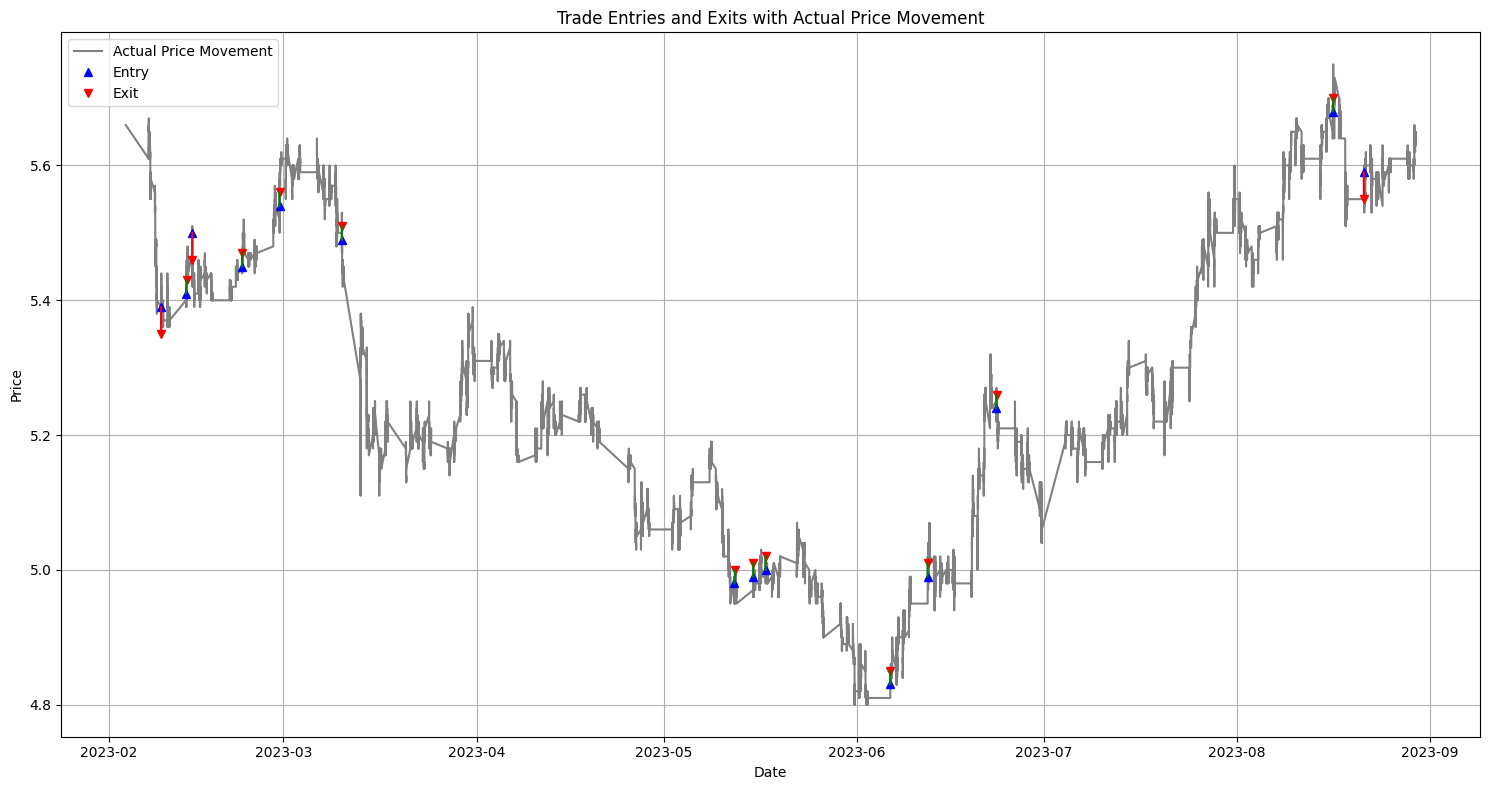

In [180]:
plot_df = trades_df.copy()
import matplotlib.pyplot as plt

# Convert string timestamps to datetime objects and set them as indices
plot_df['entry_timestamp'] = pd.to_datetime(plot_df['entry_timestamp'])
plot_df['exit_timestamp'] = pd.to_datetime(plot_df['exit_timestamp'])
plot_df = plot_df.set_index('entry_timestamp')  # Using entry_timestamp as index for plotting

# Convert UNIX timestamp (in milliseconds) to datetime and set it as the index
merged_df['time_msc'] = pd.to_datetime(merged_df['time_msc'], unit='ms')
merged_df = merged_df.set_index('time_msc')

# Plotting
plt.figure(figsize=(15, 8))

# Plotting 'last' column from merged_df
plt.plot(merged_df.index, merged_df['last'], color='grey', label='Actual Price Movement')

# Plot entry and exit points from plot_df
plt.plot(plot_df.index, plot_df['entry'], '^', color='blue', label='Entry')
plt.plot(plot_df['exit_timestamp'], plot_df['exit'], 'v', color='red', label='Exit')

# Indicating TP and SL with green and red lines respectively
for _, row in plot_df.iterrows():
    if row['type'] == 'TP':
        plt.plot([row.name, row['exit_timestamp']], [row['entry'], row['exit']], color='green')
    elif row['type'] == 'SL':
        plt.plot([row.name, row['exit_timestamp']], [row['entry'], row['exit']], color='red')

plt.title('Trade Entries and Exits with Actual Price Movement')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [181]:
result_df = result.copy()
#set end_time as index
result_df = result_df.set_index('end_time')
result_df

,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
end_time,,,,,,,,
2023-02-07 09:00:33.782,1344122.0,2023-02-07 09:00:00,4,12,33.782,1.543779e+07,NaN,Hold
2023-02-08 09:07:58.281,235730.0,2023-02-08 09:00:00,2,13,478.281,1.912333e+05,-0.987613,Sell
2023-02-09 09:00:15.285,376332.0,2023-02-09 09:00:00,10,5,15.285,9.552948e+06,48.954427,Buy
2023-02-10 09:02:11.865,517825.0,2023-02-10 09:00:00,9,7,131.865,1.523650e+06,-0.840505,Hold
2023-02-13 09:00:33.443,304633.0,2023-02-13 09:00:00,12,5,33.443,3.534300e+06,1.319627,Buy
...,...,...,...,...,...,...,...,...
2023-08-23 09:16:13.791,55806.0,2023-08-23 09:00:00,2,13,973.791,2.223550e+04,-0.719553,Sell
2023-08-24 09:10:26.525,474298.0,2023-08-24 09:00:00,8,10,626.525,2.937275e+05,12.209846,Hold
2023-08-25 09:07:49.504,61404.0,2023-08-25 09:00:00,7,8,469.504,5.074451e+04,-0.827239,Hold


In [182]:
import pandas as pd



# Merge based on the indexes (datetime) of both tick_df and result_df using a left merge
merged_df = pd.merge(left=tick_df, right=result_df, left_index=True, right_index=True, how='left')

# Sorting by the index (which is the time from tick_df)
merged_df = merged_df.sort_index()
merged_df


,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
2023-02-03 16:51:55.081,5.66,1000,1675443115081,312,1000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-03 16:53:30.105,5.66,1000,1675443210105,312,1000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-03 16:54:35.472,5.66,500,1675443275472,312,500.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:00:00.000,5.61,179800,1675760400000,344,179800.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:00:01.020,5.63,10000,1675760401020,312,10000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-29 15:45:02.078,5.63,10000,1693323902078,88,10000.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-29 15:46:09.261,5.63,2000,1693323969261,88,2000.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-29 15:46:45.066,5.63,16600,1693324005066,88,16600.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-29 15:46:45.155,5.64,400,1693324005155,56,400.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
